The main goal is to show various techniques for checking normal distribution:

1. Normal distribution parameters check
2. Hypothesis testing
3. Graphic representation of density functions.

Except for working with above methods, I will perform needed dataset modification in order to typos desposal and converting numerical variables into categorical.

## 1. Import required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats

from sklearn.preprocessing import OrdinalEncoder

## 2. Upload the dataset

In [2]:
df = pd.read_csv('books.csv', error_bad_lines=False)

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


In [3]:
skipped_lines_percent = round(4/(df.shape[0]+4)*100,4)
skipped_lines_percent

0.0359

Skipped lines account for about 0.0359 % of length of whole dataset, hence such skipping is acceptable.

## 3. Take a look at basic information about the dataset

In [4]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [5]:
df.shape

(11123, 12)

The dataset consists of **11123 rows and 12 columns**. The **columns names** are below:

In [6]:
df.columns.to_list()

['bookID',
 'title',
 'authors',
 'average_rating',
 'isbn',
 'isbn13',
 'language_code',
 '  num_pages',
 'ratings_count',
 'text_reviews_count',
 'publication_date',
 'publisher']

## 4. Dataframe modification 
### 4.1 Fix column names 

I will rename whitespace in "num_pages" column name.

In [7]:
df.columns = df.columns.str.replace(' ', '')
df.columns.to_list()

['bookID',
 'title',
 'authors',
 'average_rating',
 'isbn',
 'isbn13',
 'language_code',
 'num_pages',
 'ratings_count',
 'text_reviews_count',
 'publication_date',
 'publisher']

### 4.2 Remove needless columns

Some columns like:
* bookID
* isbn
* isbn13
* title
* authors

are not interesting from the viewpoint of distribution analysis, so they will be removed.

In [8]:
print(f'Number of columns before removing: {df.shape[1]}')
df = df.drop(['bookID', 'isbn', 'isbn13', 'title', 'authors'], axis=1)
print(f'Number of columns after removing: {df.shape[1]}')

Number of columns before removing: 12
Number of columns after removing: 7


In [9]:
df.columns.to_list()

['average_rating',
 'language_code',
 'num_pages',
 'ratings_count',
 'text_reviews_count',
 'publication_date',
 'publisher']

### 4.3 Convert some categorical data into numerical

In [10]:
df.nunique()

average_rating         209
language_code           27
num_pages              997
ratings_count         5294
text_reviews_count    1822
publication_date      3679
publisher             2290
dtype: int64

Hence column "language_code" has only 27 unique values, it can be easy mapped to numerical values.

In [11]:
df.language_code.unique()

array(['eng', 'en-US', 'fre', 'spa', 'en-GB', 'mul', 'grc', 'enm',
       'en-CA', 'ger', 'jpn', 'ara', 'nl', 'zho', 'lat', 'por', 'srp',
       'ita', 'rus', 'msa', 'glg', 'wel', 'swe', 'nor', 'tur', 'gla',
       'ale'], dtype=object)

Language codes with prefix 'en-' like: en-US, en-CA, en-GB will be replaced by 'eng'.

In [12]:
df.language_code = df.language_code.replace(to_replace ='en-..', value = 'eng', regex = True)
np.sort(df.language_code.unique())

array(['ale', 'ara', 'eng', 'enm', 'fre', 'ger', 'gla', 'glg', 'grc',
       'ita', 'jpn', 'lat', 'msa', 'mul', 'nl', 'nor', 'por', 'rus',
       'spa', 'srp', 'swe', 'tur', 'wel', 'zho'], dtype=object)

We can see that mentioned values have been replaced by 'eng'. Last thing is to convert this column to a column with numerical values.

In [13]:
before = df.language_code.unique()

enc = OrdinalEncoder()
df.language_code = enc.fit_transform(df.language_code.values.reshape(-1, 1)).astype(int)

In [14]:
pd.DataFrame(data={'before': before,
                   'after': df.language_code.unique()}).sort_values(by='before')

,before,after
23,ale,0
8,ara,1
0,eng,2
5,enm,3
1,fre,4
6,ger,5
22,gla,6
17,glg,7
4,grc,8
14,ita,9


Map of "language code" values will enable the further distribution analysis.

### 4.4 Feature engineering

### 4.4.1 Publication date
"publication_date" may be valuable for distribution analysis, especially when years will be extracted.

In [15]:
df['year'] = df.publication_date.str.rsplit("/", n=3, expand=True)[2].astype(int)
# n=3 because value is splitted into 3 parts: day, month and year
# [2] because we are interested only in 'year'

df.head(2)

,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,year
0,4.57,2,652,2095690,27591,9/16/2006,Scholastic Inc.,2006
1,4.49,2,870,2153167,29221,9/1/2004,Scholastic Inc.,2004


To avoid data leakage "publication_date" will be removed.

In [16]:
df = df.drop(['publication_date'], axis=1)
df.head(2)

,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publisher,year
0,4.57,2,652,2095690,27591,Scholastic Inc.,2006
1,4.49,2,870,2153167,29221,Scholastic Inc.,2004


## 5. Normal distribution analysis
I will perform the analysis going through 3 approaches:
* using basic stats to see normal distribution parameters.
* hypothesis testing of normal distribution
* graphic representation of density functions

Last glance at basic statistics to check if datapoints looks good.

In [17]:
df.describe()

,average_rating,language_code,num_pages,ratings_count,text_reviews_count,year
count,11123.000000,11123.000000,11123.000000,1.112300e+04,11123.000000,11123.000000
mean,3.934075,2.483503,336.405556,1.794285e+04,542.048099,2000.169019
std,0.350485,2.536299,241.152626,1.124992e+05,2576.619589,8.247227
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1900.000000
25%,3.770000,2.000000,192.000000,1.040000e+02,9.000000,1998.000000
50%,3.960000,2.000000,299.000000,7.450000e+02,47.000000,2003.000000
75%,4.140000,2.000000,416.000000,5.000500e+03,238.000000,2005.000000
max,5.000000,23.000000,6576.000000,4.597666e+06,94265.000000,2020.000000


### 5.1 Normal distribution parameters check

Parameters that are indicative for normal distribution are:
* mean 
* median 
* kurtosis
* skewness.

The mean and median [should have the same value](https://en.wikipedia.org/wiki/Normal_distribution), and kurtosis and skewness [be equal to 0](https://en.wikipedia.org/wiki/Normal_distribution).


In [18]:
df.agg(['mean', 'median', 'kurtosis', 'skew']).T

,mean,median,kurtosis,skew
average_rating,3.934075,3.96,36.222806,-3.577441
language_code,2.483503,2.00,32.946651,5.772103
num_pages,336.405556,299.00,62.415973,4.271778
ratings_count,17942.848063,745.00,442.271674,17.693952
text_reviews_count,542.048099,47.00,396.565060,16.175096
year,2000.169019,2003.00,16.259456,-2.992627


Mean and median have similar values for: 
* average_rating (left-skewed distribution)
* num_pages (right-skewed distribution)
* language_code (right-skewed distribution)
* year (with a skew that is the closest to 0, left-skewed distribution)

The "year" and "average_rating" are our front-runners in the race for normal distribution ;)

### 5.2 Hypothesis testing

In [19]:
results = []
p_value_list = []
alpha = 0.05

for i in df._get_numeric_data().columns:
    p_value = scipy.stats.normaltest(df[i])[1] # to get only p_value without a statistic
    p_value_list.append(p_value)
    if p_value < alpha:
        results.append('rejected')
    else:
        results.append('not rejected')
        
pd.DataFrame(data={'variable': df._get_numeric_data().columns,
                    'p_value': p_value_list,
                    'null hypothesis': results})

,variable,p_value,null hypothesis
0,average_rating,0.0,rejected
1,language_code,0.0,rejected
2,num_pages,0.0,rejected
3,ratings_count,0.0,rejected
4,text_reviews_count,0.0,rejected
5,year,0.0,rejected


According to hypothesis testing, none of variables comes from a normal distribution. It's hard to find a feature that is the closest to be normal because all p value are 0.

### 5.3 Graphic representation of density functions

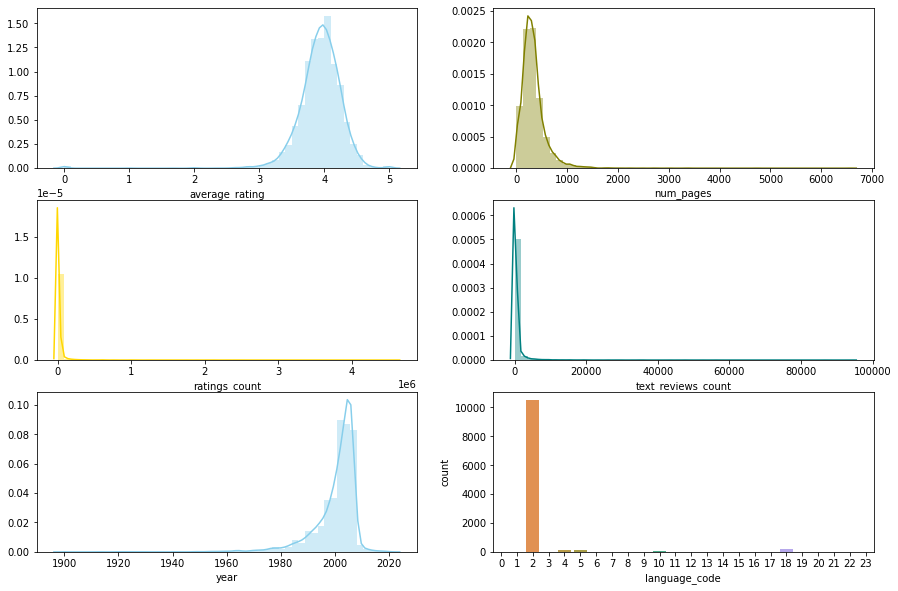

In [20]:
f, axes = plt.subplots(3,2, figsize=(15, 10))
sns.distplot(df.average_rating, color='skyblue', ax=axes[0, 0])
sns.distplot(df.num_pages, color='olive', ax=axes[0, 1])
sns.distplot(df.ratings_count, color='gold', ax=axes[1, 0])
sns.distplot(df.text_reviews_count, color='teal', ax=axes[1, 1])
sns.distplot(df.year, color='skyblue', ax=axes[2, 0])
sns.countplot(x = 'language_code', data = df, ax=axes[2,1])
plt.show()

As we can see, "average_rating" is the most normal variable.

## 6. Conlusion

The dataset consisted of 12 columns. Five of them (bookID, isbn, isbn13, title and authors) have been removed because checking them for statistics wasn't reasonable. 
The column "publication_date" has been replaced by column "year".  
Eventually, the dataset had 7 columns: categorical ("language_code" and "publisher") and numerical (the rest).

Use of 3 different methods showed different results. Despite the fact that the distribution of "average_rating" variable looks like a normal distribution (5.3), then none of the numerical variables hasn't a normal distribution (5.1 and 5.2). 